### Download and analyze the US census data

Census data is important data sources for the urban analytics. In this tutorial, we are going to download the census data and analyze the socio-economic variables in the census data. 

  1. Prepare required modules and import modules
  2. County level census data
  3. Census tract level census data
  4. Block group level census data
  5. Create choropleth map.

### 1. Prepare required modules and import modules
Uncomment of the following statement and run the cell. 

In [1]:
# !pip install census
# !pip install us

In [3]:
# Import modules
# import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os, os.path

# Set API key
c = Census("a4b2eab7c7050050923fffa485fb81e22be63e68")

### 2. County level census data

In [3]:
df_lst = []
# Access shapefile of 24 for Maryland census tracts
ct_shp = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip")
ct_shp = ct_shp.to_crs(epsg = 4326)

# for more details of different variables, https://api.census.gov/data/2019/acs/acs5/variables.html
variable_list = ["B01001H_001E", #nonHispanic white alone
                  "B03002_012E", #Hispanic
                  "B02001_003E", #black alone
                  "B02001_005E", #asian alone
                  "B19013_001E", #per capita income
                  "B06009_002E", # "less highschool", \
                  "B06009_005E", # "bachelor", \
                  "B06009_001E", # "totalEducation", \                  
                  "B01003_001E"] #total population

for state in states.STATES:
    state_name = state.name
    # abbr_state = states.lookup(state.name).fips #abbr
    fips_state = states.lookup(state_name).fips #abbr
    print("The state and abbreation are:", state, fips_state)
    
    ### census tract level census data
    ct_census_data = c.acs5.state_county(fields = variable_list,
                                          state_fips = fips_state,
                                          county_fips = "*",
                                          year = 2020)
    
    # Create a dataframe from the census data
    ct_census_df = pd.DataFrame(ct_census_data)
    
    # Combine state, county, and tract columns together to create a new string and assign to new column
    # https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html
    ct_census_df["GEOID"] = ct_census_df["state"] + ct_census_df["county"]

    # Join the attributes of the dataframes together
    # Source: https://geopandas.org/docs/user_guide/mergingdata.html
    census_merge = ct_shp.merge(ct_census_df, on = "GEOID")
    df_lst.append(census_merge) #each state is one item, put all the states data into one list


# Concatenate all the counties in all state (similar with the append operation in arcgis)
census_df_us = pd.concat(df_lst, axis=0)


The state and abbreation are: Alabama 01
The state and abbreation are: Alaska 02
The state and abbreation are: Arizona 04
The state and abbreation are: Arkansas 05
The state and abbreation are: California 06
The state and abbreation are: Colorado 08
The state and abbreation are: Connecticut 09
The state and abbreation are: Delaware 10
The state and abbreation are: Florida 12
The state and abbreation are: Georgia 13
The state and abbreation are: Hawaii 15
The state and abbreation are: Idaho 16
The state and abbreation are: Illinois 17
The state and abbreation are: Indiana 18
The state and abbreation are: Iowa 19
The state and abbreation are: Kansas 20
The state and abbreation are: Kentucky 21
The state and abbreation are: Louisiana 22
The state and abbreation are: Maine 23
The state and abbreation are: Maryland 24
The state and abbreation are: Massachusetts 25
The state and abbreation are: Michigan 26
The state and abbreation are: Minnesota 27
The state and abbreation are: Mississippi 2

In [7]:
states.STATES[0].name

'Alabama'

#### calculate the variables and save the results into a shapefile

In [10]:
va_poverty_tract = census_df_us[["STATEFP", "GEOID", "geometry"] + variable_list]

# Get poverty rate and store values in new column
va_poverty_tract["white"] = (va_poverty_tract["B01001H_001E"]) / va_poverty_tract["B01003_001E"] * 100
va_poverty_tract["hispanic"] = (va_poverty_tract["B03002_012E"]) / va_poverty_tract["B01003_001E"] * 100
va_poverty_tract["black"] = (va_poverty_tract["B02001_003E"]) / va_poverty_tract["B01003_001E"] * 100
va_poverty_tract["asian"] = (va_poverty_tract["B02001_005E"]) / va_poverty_tract["B01003_001E"] * 100
va_poverty_tract["income"] = va_poverty_tract["B19013_001E"]
# va_poverty_tract["builtage"] = 2023 - va_poverty_tract["B25034_001E"]*1.0
va_poverty_tract["education"] = (va_poverty_tract["B06009_005E"])/va_poverty_tract["B06009_001E"]*100

# drop the unnecessary columns
dfRes = va_poverty_tract[["STATEFP", "geometry", "income", "white", "black", "hispanic", "asian", "education"]]
dfRes.to_file("county.shp")


/Users/tul69181/anaconda3/envs/geospatial/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/tul69181/anaconda3/envs/geospatial/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/tul69181/anaconda3/envs/geospatial/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to b

### 3. Census tract level census data
We can narrow down to the census tract level. 

In [15]:
outdir = 'censustract'
if not os.path.exists(outdir):
    os.mkdir(outdir)

## loop to different states, you can also specify the state name
for state in states.STATES:
    state_name = state.name
    # abbr_state = states.lookup(state.name).fips #abbr
    fips_state = states.lookup(state_name).fips #abbr
    print("The state and abbreation are:", state, fips_state)
    
    ct_shp = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_%s_tract.zip"%(fips_state))
    ct_shp = ct_shp.to_crs(epsg = 4326)
    
    # Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
    ### census tract level
    ct_census_data = c.acs5.state_county_tract(fields = variable_list,
                                                state_fips = fips_state,
                                                county_fips = "*",
                                                tract = "*",
                                                year = 2020)
    
    # Create a dataframe from the census data
    ct_census_df = pd.DataFrame(ct_census_data)
    
    # Combine state, county, and tract columns together to create a new string and assign to new column
    # https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html
    ct_census_df["GEOID"] = ct_census_df["state"] + ct_census_df["county"] + ct_census_df["tract"]
    
    # Join the attributes of the dataframes together
    # Source: https://geopandas.org/docs/user_guide/mergingdata.html
    census_merge = ct_shp.merge(ct_census_df, on = "GEOID")
    
    # Create new dataframe from select columns
    va_poverty_tract = census_merge[["STATEFP", "COUNTYFP", "GEOID", "geometry"] + variable_list]
    
    # Get poverty rate and store values in new column
    va_poverty_tract["white"] = (va_poverty_tract["B01001H_001E"]) / va_poverty_tract["B01003_001E"] * 100
    va_poverty_tract["hispanic"] = (va_poverty_tract["B03002_012E"]) / va_poverty_tract["B01003_001E"] * 100
    va_poverty_tract["black"] = (va_poverty_tract["B02001_003E"]) / va_poverty_tract["B01003_001E"] * 100
    va_poverty_tract["asian"] = (va_poverty_tract["B02001_005E"]) / va_poverty_tract["B01003_001E"] * 100
    va_poverty_tract["income"] = va_poverty_tract["B19013_001E"]
    # va_poverty_tract["builtage"] = 2023 - va_poverty_tract["B25034_001E"]*1.0
    va_poverty_tract["education"] = (va_poverty_tract["B06009_005E"] - va_poverty_tract["B06009_002E"])/va_poverty_tract["B06009_001E"]*100
    
    # drop the unnecessary columns
    dfRes = va_poverty_tract[["STATEFP", "COUNTYFP", "geometry", "income", "white", "black", "hispanic", "asian", "education"]]
    
    state_gpd_race = dfRes[["white", "black", "hispanic", "asian"]]
    
    # dfRes['incomeQuntile'] = pd.qcut(dfRes['income'], 4, labels=False) #income quantile
    dfRes.to_file(os.path.join(outdir, "%s.shp"%(state_name)))

    ### if you don't want to download for the whole United States, you can specify the state name
    break

The state and abbreation are: Alabama 01


/Users/tul69181/anaconda3/envs/geospatial/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/tul69181/anaconda3/envs/geospatial/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/tul69181/anaconda3/envs/geospatial/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to b

### 4. Block group level census data

In [19]:
outdir = r'blockgroup'

if not os.path.exists(outdir):
    os.mkdir(outdir)

variable_list = ["B02001_002E", #nonHispanic white alone, #nonHispanic white alone, , B01001H_001E no hispanic white is null for blockgroup
                  "B03002_012E", #Hispanic
                  "B02001_003E", #black alone
                  "B02001_005E", #asian alone
                  "B19013_001E", #per capita income
                  "B06009_002E", # "less highschool", \
                  "B06009_005E", # "bachelor", \
                  "B06009_001E", # "totalEducation", \                  
                  "B01003_001E"]

# Reproject shapefile to UTM Zone 17N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
for state in states.STATES:
    state_name = state.name
    if state_name != 'Pennsylvania': 
        continue
    
    # abbr_state = states.lookup(state.name).fips #abbr
    fips_state = states.lookup(state_name).fips #abbr
    print("The state and abbreation are:", state, fips_state)
    
    ct_shp = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/BG/tl_2020_%s_bg.zip"%(fips_state))
    ct_shp = ct_shp.to_crs(epsg = 4326)

    # Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
    ### census tract level
    ct_census_data = c.acs5.state_county_blockgroup(fields = variable_list,
                                                    state_fips = fips_state,
                                                    county_fips = "*",
                                                    blockgroup = "*",
                                                    year = 2020)
    
    # Create a dataframe from the census data
    ct_census_df = pd.DataFrame(ct_census_data)
    
    # Combine state, county, and tract columns together to create a new string and assign to new column
    # https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html
    ct_census_df["GEOID"] = ct_census_df["state"] + ct_census_df["county"] + ct_census_df["tract"] + ct_census_df["block group"]

    # Join the attributes of the dataframes together
    # Source: https://geopandas.org/docs/user_guide/mergingdata.html
    census_merge = ct_shp.merge(ct_census_df, on = "GEOID")

    # Create new dataframe from select columns       
    va_poverty_tract = census_merge[["STATEFP", "COUNTYFP", "GEOID", "geometry"] + variable_list]

    # Get poverty rate and store values in new column
    va_poverty_tract["white"] = (va_poverty_tract["B02001_002E"]) / va_poverty_tract["B01003_001E"] * 100
    va_poverty_tract["hispanic"] = (va_poverty_tract["B03002_012E"]) / va_poverty_tract["B01003_001E"] * 100
    va_poverty_tract["black"] = (va_poverty_tract["B02001_003E"]) / va_poverty_tract["B01003_001E"] * 100
    va_poverty_tract["asian"] = (va_poverty_tract["B02001_005E"]) / va_poverty_tract["B01003_001E"] * 100
    va_poverty_tract["income"] = va_poverty_tract["B19013_001E"]
    # va_poverty_tract["builtage"] = 2023 - va_poverty_tract["B25034_001E"]*1.0
    va_poverty_tract["education"] = (va_poverty_tract["B06009_005E"] - va_poverty_tract["B06009_002E"])/va_poverty_tract["B06009_001E"]*100
    
    # drop the unnecessary columns
    dfRes = va_poverty_tract[["STATEFP", "COUNTYFP", "GEOID", "geometry", "income", "white", "black", "hispanic", "asian", "education"]]
    
    # state_census = dfRes.dissolve(by='STATEFP', aggfunc='mean')
    state_gpd_race = dfRes[["white", "black", "hispanic", "asian"]]
    
    # dfRes['incomeQuntile'] = pd.qcut(dfRes['income'], 4, labels=False) #income quantile
    dfRes.to_file(os.path.join(outdir, "%s.shp"%(state_name)))
    
    break
    

The state and abbreation are: Pennsylvania 42


/Users/tul69181/anaconda3/envs/geospatial/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/tul69181/anaconda3/envs/geospatial/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/tul69181/anaconda3/envs/geospatial/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to b

In [18]:
state_name

'Alabama'

In [20]:
### Philadelphia county, 101

In [24]:
phily_census = dfRes[dfRes['COUNTYFP'] == '101']

In [25]:
phily_census.head()

,STATEFP,COUNTYFP,GEOID,geometry,income,white,black,hispanic,asian,education
88,42,101,421010190001,"POLYGON ((-75.10314 40.00620, -75.10283 40.007...",-666666666.0,34.543326,9.836066,85.597190,0.000000,NaN
89,42,101,421010191003,"POLYGON ((-75.11181 40.01366, -75.10965 40.013...",63839.0,24.709609,5.702218,69.588173,25.765576,NaN
90,42,101,421010197003,"POLYGON ((-75.13878 40.01868, -75.13846 40.020...",-666666666.0,48.253275,31.441048,52.620087,0.000000,NaN
91,42,101,421010199001,"POLYGON ((-75.14099 40.00553, -75.14083 40.006...",10884.0,19.836553,43.462110,74.368499,0.000000,NaN
92,42,101,421010200001,"POLYGON ((-75.15372 39.99799, -75.15368 39.998...",35702.0,1.126126,77.027027,19.819820,0.000000,NaN


### 5. Filter out county of Philadelphlia, and create choropleth map

You can skip this part for this lab. We will continue to talk about this in following weeks. 

/var/folders/1j/rxctbd0d60l078ctybj6ktrr673nl9/T/ipykernel_68695/3855680649.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlGnBu', n_class)


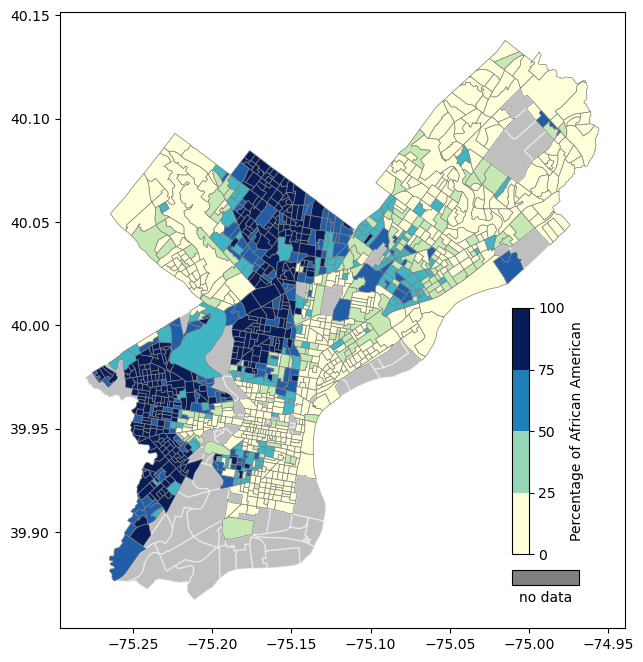

In [139]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
import mapclassify as mc
from matplotlib.colors import rgb2hex

# create a plot for the choropleth map
f, ax = plt.subplots(1, figsize=(8, 8))

# the number of categories
n_class = 4

# set the color scheme
cmap = plt.cm.get_cmap('YlGnBu', n_class)

### modify the cmap to add a new color
cmap_list = [rgb2hex(cmap(i)) for i in range(cmap.N)]
cmap_list.insert(0, 'grey')
cmap_with_grey = ListedColormap(cmap_list)
greyblock = ListedColormap(['grey'])

# set the location of the legend
axins = ax.inset_axes([0.8, 0.12, 0.03, 0.4]) #x0, y0, width, height
axins_grey = ax.inset_axes([0.8, 0.07, 0.12, 0.025]) #x0, y0, width, height


# the field to plot the choropleth map
field = 'black'

phily_census.plot(ax = ax, alpha=0.5, color='grey', edgecolor='w')

# plot the choropleth map of blood lead in Philadelphia
phily_census.plot(column=field, 
                 cmap='YlGnBu', 
                 edgecolor='0.5',
                 ax = ax,
                 linewidth=0.5,
                 scheme='equal_interval')

# the function should be matched with the scheme of the above geopandas plot, https://pysal.org/mapclassify/_modules/mapclassify/classifiers.html
nb = mc.EqualInterval(phily_census[field].dropna(), k=n_class) # NaturalBreaks, FisherJenks, quantile
vals = list(nb.bins) #get the interval labels
vals.insert(0, phily_census[field].min())


# create a color bar for the map
norm = Normalize(vmin=phily_census[field].min(), vmax=phily_census[field].max())
n_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)
n_cmap_grey = cm.ScalarMappable(norm=norm, cmap=greyblock)


cbar = ax.get_figure().colorbar(n_cmap, 
                                orientation='vertical', 
                                cax = axins,
                                fraction=0.046, 
                                pad=0.2, 
                                ticks=vals,
                                shrink=0.4)
cbar.ax.set_ylabel('Percentage of African American')

cbar2 = ax.get_figure().colorbar(n_cmap_grey, 
                                orientation='horizontal', 
                                cax = axins_grey,
                                fraction=0.046, 
                                pad=0.2, 
                                label="no data",
                                shrink=0.4)
cbar2.set_ticks([])

# ax.set_axis_off()
# plt.axis('equal')

# # save the geoviz into a png file locally
# plt.savefig("PhiladelphiaBloodLead.png", bbox_inches='tight', pad_inches=0.1, dpi=1000)

plt.show(f)
